In [1]:
import pandas as pd
import numpy as np
import warnings as warn
warn.filterwarnings('ignore')

In [2]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults

In [3]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
from pmdarima import auto_arima

In [5]:
df1 = pd.read_csv('Data/DailyTotalFemaleBirths.csv', index_col='Date', parse_dates=True)
df1.index.freq = 'D'
df1 = df1[:120]

In [6]:
df2 = pd.read_csv('Data/TradeInventories.csv', index_col='Date', parse_dates=True)
df2.index.freq = 'MS'

# ARMA

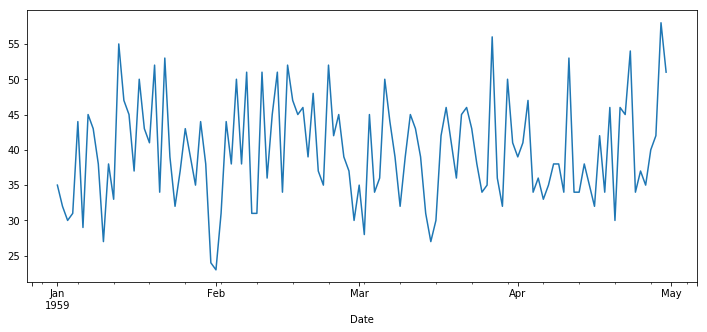

In [7]:
df1['Births'].plot(figsize=(12,5))

In [8]:
# Confirm stationarity

def adf_test(series,title=''):
    from statsmodels.tsa.stattools import adfuller
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [9]:
test = pd.DataFrame(adf_test(df1['Births']))


Augmented Dickey-Fuller Test: 
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Fit ARIMA: order=(2, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0); AIC=823.489, BIC=829.064, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=824.647, BIC=833.010, Fit time=0.035 seconds
Fit ARIMA: order=(0, 0, 1); AIC=824.747, BIC=833.110, Fit time=0.045 seconds
Fit ARIMA: order=(1, 0, 1); AIC=826.399, BIC=837.549, Fit time=0.123 seconds
Total fit time: 0.617 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(0, 0)   Log Likelihood                -409.745
Method:                           css   S.D. of innovations              7.357
Date:                Wed, 12 May 2021   AIC                            823.489
Time:                        12:54:38   BIC                            829.064
Sample:                             0   HQIC                           825.753
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.7833      0.672     59.240      0.000      38.467      41.100
==============================================================================
"""

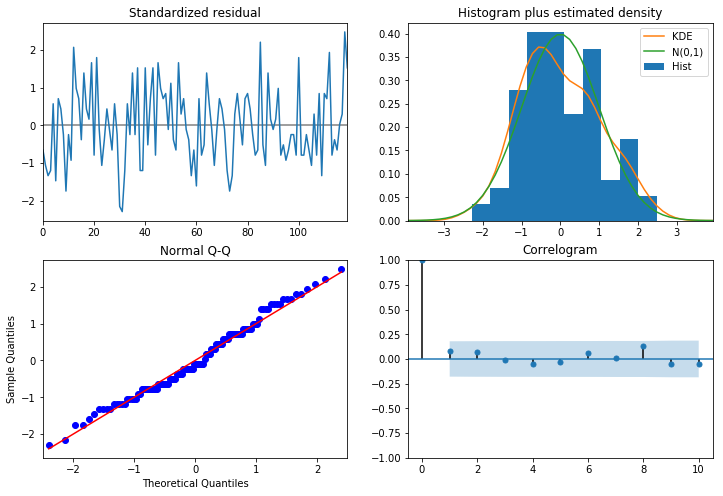

In [10]:
model = auto_arima(df1['Births'], seasonal=False,stationarity=True, trace=True, error_action='ignore',
          suppress_warnings=True, m=12)
model.plot_diagnostics(figsize=(12,8))
model.summary()

In [11]:
#help(auto_arima)

In [12]:
# Separate training and test set
train = df1.iloc[:90]
test = df1.iloc[90:]


In [13]:
model = ARMA(train['Births'], order=(2,2))
result = model.fit()

In [14]:
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Wed, 12 May 2021   AIC                            627.809
Time:                        12:54:42   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7433           +0.0000j            1.7433            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

In [15]:
print(result)

In [16]:
# Create predicted values
print(len(df1))
start = len(train)
end = len(train) + len(test)

print(start)
print(end)

120
90
120


In [17]:
predictions = result.predict(start, end)

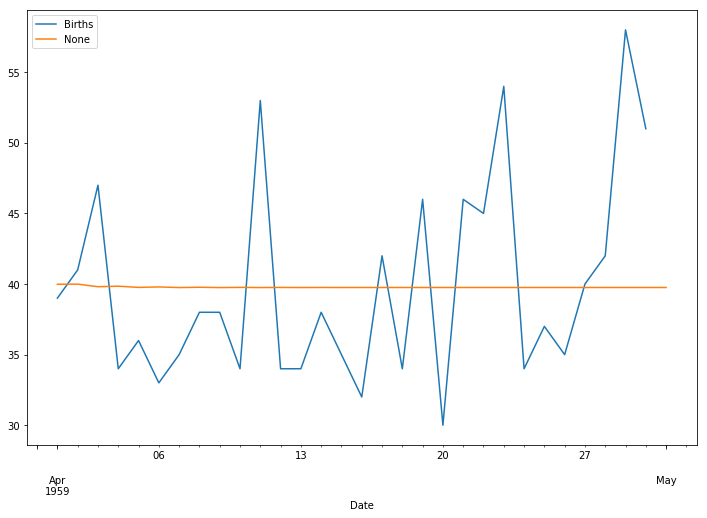

In [18]:
test['Births'].plot(figsize=(12,8), legend=True)
predictions.plot(legend=True)

In [19]:
test.mean()

Births    39.833333
dtype: float64

In [20]:
predictions.mean()

39.776704882663054

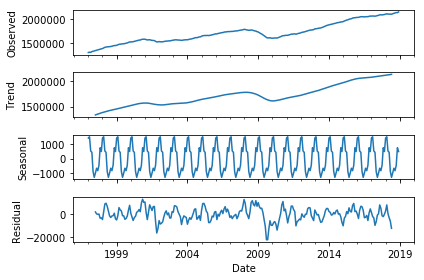

In [21]:
# Fit on different dataset
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df2['Inventories'], model='add')
result.plot();

In [23]:
auto_arima(df2['Inventories'], seasonal=False, stationary=False).summary()

C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(3, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.264
Date:                Wed, 12 May 2021   AIC                           5228.505
Time:                        12:55:46   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3456.0977   1312.263      2.634      0.009     884.110    6028.085
ar.L1.D.y      0.9037      0.039     23.406      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.544      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
# Run ADF test 
from statsmodels.tsa.statespace.tools import diff

In [26]:
df2['Diff_1'] = diff(df2['Inventories'], k_diff=1)

In [27]:
adf_test(df2['Diff_1']) #Agrees with ARIMA model results

Augmented Dickey-Fuller Test: 
ADF test statistic       -3.412249
p-value                   0.010548
# lags used               4.000000
# observations          258.000000
critical value (1%)      -3.455953
critical value (5%)      -2.872809
critical value (10%)     -2.572775
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


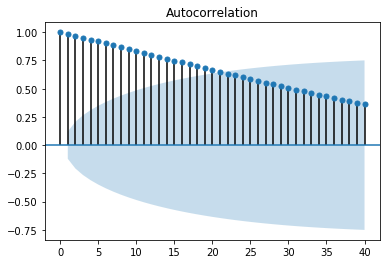

In [29]:
# Run ACF and PACF plots
plot_acf(df2['Inventories'], lags=40);

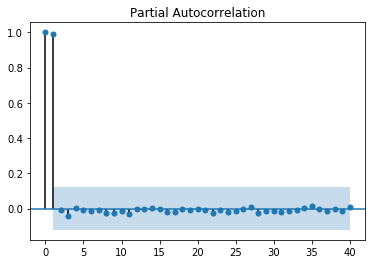

In [30]:
plot_pacf(df2['Inventories'], lags=40);

In [34]:
#AR = 1
# I = 1
#MA = 1

stepwise_fit = auto_arima(df2['Inventories'], start_p=0, start_q=0, max_p=2, max_q=2, seasonal=False, 
                         trace=True)

summary = stepwise_fit.summary()
summary

Fit ARIMA: order=(0, 1, 0); AIC=5348.037, BIC=5355.181, Fit time=0.010 seconds
Fit ARIMA: order=(1, 1, 0); AIC=5250.883, BIC=5261.599, Fit time=0.172 seconds
Fit ARIMA: order=(0, 1, 1); AIC=5283.095, BIC=5293.811, Fit time=0.131 seconds
Fit ARIMA: order=(2, 1, 0); AIC=5240.553, BIC=5254.841, Fit time=0.277 seconds
Fit ARIMA: order=(2, 1, 1); AIC=5229.528, BIC=5247.388, Fit time=0.366 seconds
Fit ARIMA: order=(1, 1, 1); AIC=5228.505, BIC=5242.794, Fit time=0.478 seconds
Fit ARIMA: order=(1, 1, 2); AIC=5229.289, BIC=5247.150, Fit time=0.591 seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 2.140 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  263
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2610.253
Method:                       css-mle   S.D. of innovations           4938.264
Date:                Wed, 12 May 2021   AIC                           5228.505
Time:                        13:07:59   BIC                           5242.794
Sample:                             1   HQIC                          5234.247
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3456.0977   1312.263      2.634      0.009     884.110    6028.085
ar.L1.D.y      0.9037      0.039     23.406      0.000       0.828       0.979
ma.L1.D.y     -0.5732      0.076     -7.544      0.000      -0.722      -0.424
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1066           +0.0000j            1.1066            0.0000
MA.1            1.7447           +0.0000j            1.7447            0.0000
-----------------------------------------------------------------------------
"""

In [35]:
################### Making predictions on ARIMA fit ######################################
len(df2)

264

In [37]:
train = df2.iloc[:252]
test = df2.iloc[252:]

model = ARIMA(train['Inventories'], order=(1,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.Inventories   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2486.395
Method:                       css-mle   S.D. of innovations           4845.028
Date:                Wed, 12 May 2021   AIC                           4980.790
Time:                        13:10:35   BIC                           4994.892
Sample:                    02-01-1997   HQIC                          4986.465
                         - 12-01-2017                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3197.5697   1344.869      2.378      0.018     561.675    5833.464
ar.L1.D.Inventories     0.9026      0.039     23.011      0.000       0.826       0.979
ma.L1.D.Inventories    -0.5581      0.079     -7.048      0.000      -0.713      -0.403
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1080           +0.0000j            1.1080            0.0000
MA.1            1.7918           +0.0000j            1.7918            0.0000
-----------------------------------------------------------------------------
"""

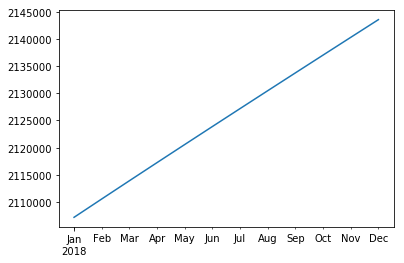

In [40]:
start = len(train)
end = len(train) + len(test) - 1

predictions = results.predict(start=start, end=end, typ='levels').rename('ARIMA(1,1,1) Predictions')
predictions.plot()

In [41]:
predictions

2018-01-01    2.107148e+06
2018-02-01    2.110526e+06
2018-03-01    2.113886e+06
2018-04-01    2.117231e+06
2018-05-01    2.120561e+06
2018-06-01    2.123878e+06
2018-07-01    2.127184e+06
2018-08-01    2.130479e+06
2018-09-01    2.133764e+06
2018-10-01    2.137041e+06
2018-11-01    2.140311e+06
2018-12-01    2.143573e+06
Freq: MS, dtype: float64

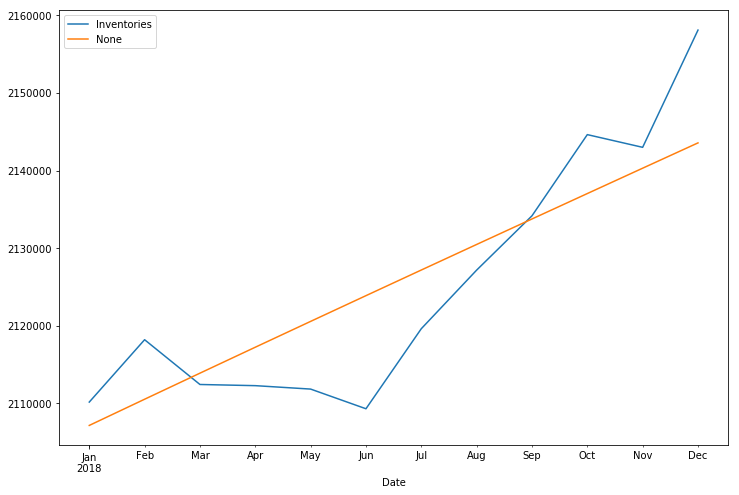

In [43]:
test['Inventories'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

In [44]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['Inventories'], predictions)

In [45]:
error

7789.597204690309

In [48]:
test['Inventories'].mean()

2125075.6666666665

In [49]:
predictions.mean()

2125465.2657303615

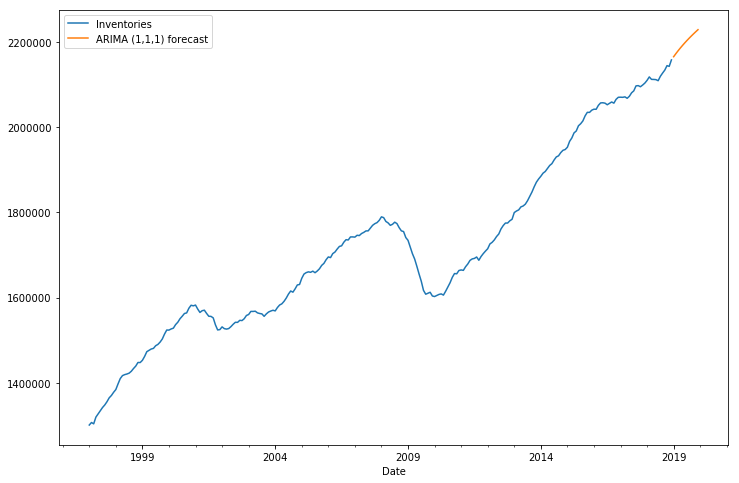

In [51]:
# Forecasting into the future

model = ARIMA(df2['Inventories'], order=(1,1,1))
results = model.fit()
fcast = results.predict(start=len(df2), end=len(df2)+11, typ="levels").rename('ARIMA (1,1,1) forecast')

df2['Inventories'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True)

In [52]:
print(fcast)

2019-01-01    2.165605e+06
2019-02-01    2.172706e+06
2019-03-01    2.179456e+06
2019-04-01    2.185888e+06
2019-05-01    2.192034e+06
2019-06-01    2.197921e+06
2019-07-01    2.203573e+06
2019-08-01    2.209014e+06
2019-09-01    2.214264e+06
2019-10-01    2.219340e+06
2019-11-01    2.224261e+06
2019-12-01    2.229041e+06
Freq: MS, Name: ARIMA (1,1,1) forecast, dtype: float64


# Seasonal ARIMA models SARIMA



In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima

In [76]:
df = pd.read_csv('Data/co2_mm_mlo.csv')
df.head()

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86


In [77]:
dict(year=df['year'], month=df['month'], day=1)

df['date'] = pd.to_datetime({'year': df['year'], 'month': df['month'], 'day':1})
df.head()

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
year            729 non-null int64
month           729 non-null int64
decimal_date    729 non-null float64
average         722 non-null float64
interpolated    729 non-null float64
date            729 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.2 KB


In [79]:
df = df.set_index('date')


In [80]:
df.head()

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86


In [81]:
df.index.freq = 'MS'

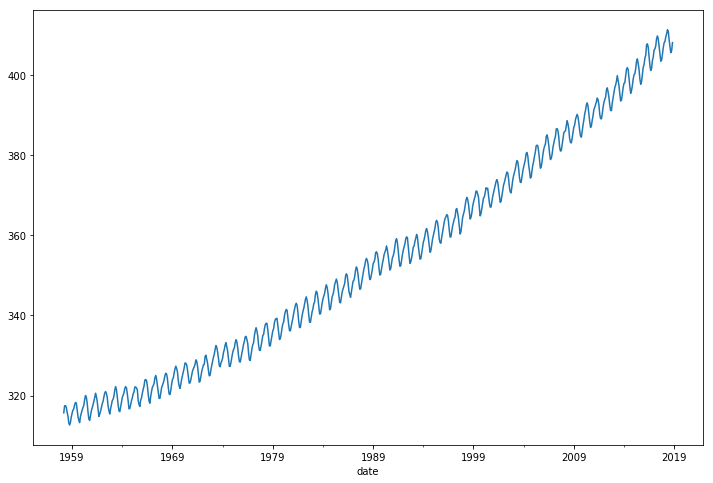

In [82]:
df['interpolated'].plot(figsize=(12,8))

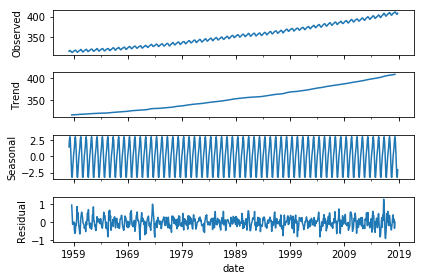

In [84]:
result = seasonal_decompose(df['interpolated'], model='add')
result.plot();

In [89]:
# Run auto_arima model
auto_arima(df['interpolated'], seasonal = True, m=12, trace=True).summary()

C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=454.496, BIC=491.218, Fit time=7.543 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=2369.532, BIC=2378.713, Fit time=0.073 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=804.125, BIC=822.486, Fit time=2.655 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=1614.808, BIC=1633.170, Fit time=2.434 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 1, 12); AIC=1101.976, BIC=1134.108, Fit time=8.487 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 1, 12); AIC=459.096, BIC=500.409, Fit time=17.310 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 0, 12); AIC=758.945, BIC=791.077, Fit time=10.554 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(2, 1, 2) seasonal_order=(1, 0, 2, 12); AIC=498.472, BIC=539.784, Fit time=15.619 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 12); AIC=1440.918, BIC=1468.460, Fit time=1.124 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(2, 1, 2) seasonal_order=(2, 0, 2, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=450.818, BIC=482.950, Fit time=8.136 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=440.448, BIC=467.990, Fit time=9.181 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 12); AIC=501.795, BIC=520.157, Fit time=4.785 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=1546.940, BIC=1569.892, Fit time=1.771 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=455.570, BIC=487.702, Fit time=13.640 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 0, 12); AIC=788.825, BIC=811.776, Fit time=2.745 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=463.180, BIC=495.312, Fit time=15.334 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=1785.006, BIC=1803.368, Fit time=0.229 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(1, 1, 1) seasonal_order=(2, 0, 2, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)
C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 12); AIC=425.558, BIC=448.509, Fit time=7.365 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 2) seasonal_order=(1, 0, 1, 12); AIC=430.125, BIC=457.667, Fit time=7.583 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 1, 12); AIC=427.628, BIC=455.170, Fit time=12.128 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 0, 12); AIC=791.154, BIC=809.516, Fit time=1.716 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 12); AIC=431.639, BIC=459.181, Fit time=13.384 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 12); AIC=1935.623, BIC=1949.394, Fit time=0.153 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 0, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Total fit time: 164.055 seconds


C:\ProgramData\Anaconda3\envs\tsa_course\lib\site-packages\pmdarima\arima\auto.py:870: ModelFitWarning: Unable to fit ARIMA for order=(0, 1, 1) seasonal_order=(2, 0, 2, 12); data is likely non-stationary. (if you do not want to see these warnings, run with error_action="ignore")
  ModelFitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  729
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -207.779
Date:                            Wed, 12 May 2021   AIC                            425.558
Time:                                    15:02:49   BIC                            448.509
Sample:                                         0   HQIC                           434.414
                                            - 729                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.001      0.901      0.368      -0.001       0.002
ma.L1         -0.3489      0.035     -9.934      0.000      -0.418      -0.280
ar.S.L12       0.9996      0.000   3150.051      0.000       0.999       1.000
ma.S.L12      -0.8695      0.022    -40.408      0.000      -0.912      -0.827
sigma2         0.0975      0.005     20.121      0.000       0.088       0.107
===================================================================================
Ljung-Box (Q):                       52.38   Jarque-Bera (JB):                 3.38
Prob(Q):                              0.09   Prob(JB):                         0.18
Heteroskedasticity (H):               1.12   Skew:                            -0.03
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
len(df)

729

In [92]:
train = df.iloc[:717]
test = df.iloc[717:]
model = SARIMAX(train['interpolated'], order=(0,1,1), 
               seasonal_order=(1,0,1,12))

In [93]:
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                       interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                -205.153
Date:                            Wed, 12 May 2021   AIC                            418.305
Time:                                    15:44:53   BIC                            436.600
Sample:                                03-01-1958   HQIC                           425.370
                                     - 11-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3724      0.034    -11.027      0.000      -0.439      -0.306
ar.S.L12       0.9997      0.000   3315.627      0.000       0.999       1.000
ma.S.L12      -0.8656      0.023    -38.003      0.000      -0.910      -0.821
sigma2         0.0958      0.005     20.479      0.000       0.087       0.105
===================================================================================
Ljung-Box (Q):                       52.04   Jarque-Bera (JB):                 3.85
Prob(Q):                              0.10   Prob(JB):                         0.15
Heteroskedasticity (H):               1.13   Skew:                            -0.02
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
start = len(train)
end = len(train) + len(test) -1
predictions = results.predict(start, end, typ='levels').rename('SARIMA Predictions')

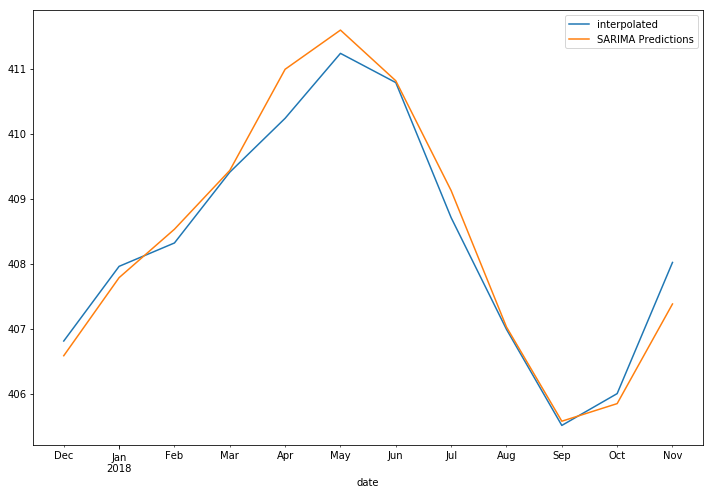

In [96]:
test['interpolated'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)

In [101]:
from statsmodels.tools.eval_measures import rmse
error = rmse(test['interpolated'], predictions)
error

0.34620220862014567

In [102]:
test['interpolated'].mean()

408.3333333333333

In [103]:
predictions.mean()

408.3919921876333

In [104]:
# Forecast the motherfucking future
model = SARIMAX(train['interpolated'], order=(0,1,1), 
               seasonal_order=(1,0,1,12))

results = model.fit()


In [111]:
horizon = 30
fcast = results.predict(len(df), len(df)+horizon, typ='levels').rename('SARIMA FORECAST')

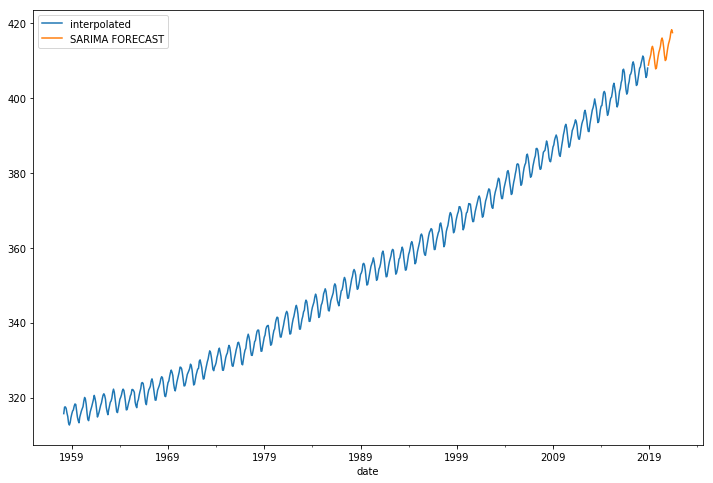

In [112]:
df['interpolated'].plot(legend=True, figsize=(12,8))
fcast.plot(legend=True)